In [24]:
!cd opa2vec && python2 runOPA2Vec.py -ontology ../data/go.obo -associations ../data/yeast-assoc.txt -reasoner elk -outfile ../data/yeast.vec

***********OPA2Vec Running ...***********

***********Ontology Processing ...***********

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
[Fatal Error] :1:1: Content is not allowed in prolog.
Loading of Axioms ...
Loading ...
    1%
    2%
    3%
    4%
    5%
    6%
    8%
    10%
    11%
    12%
    15%
    18%
    20%
    23%
    26%
    28%
    31%
    34%
    35%
    38%
    41%
    44%
    46%
    49%
    52%
    55%
    58%
    61%
    63%
    66%
    68%
    71%
    74%
    76%
    79%
    82%
    84%
    87%
    90%
    93%
    96%
    99%
    ... finished
    ... finished
Property Saturation Initialization ...
    ... finished
Reflexive Property Computation ...
    ... finished
Object Property Hierarchy and Composition Computation ...
    ... finished
Context Initialization ...
    ... finished
Consistency Checking .

In [25]:
import numpy as np
import pandas as pd

with open('data/yeast-entities.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content] 


embeddings = pd.read_csv('data/yeast.vec', header = None, skiprows = 1, sep = ' ')
embds_data = embeddings.values
embeddings_dict = dict(zip(embds_data[:,0],embds_data[:,1:-1]))
yeast_dict = {}
for i in content:
    if i in embeddings_dict:
        yeast_dict[i] = embeddings_dict[i]
        

In [ ]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

size = len(yeast_dict['4932.Q0045'])
embeds = np.zeros((len(yeast_dict), size), dtype=np.float32)

for i, emb in enumerate(yeast_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(yeast_dict.keys()):
    nodemap[i] = m

X = TSNE(n_components=2, verbose=1, n_iter=5000).fit_transform(embeds)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3923 samples in 0.015s...
[t-SNE] Computed neighbors for 3923 samples in 5.235s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3923
[t-SNE] Computed conditional probabilities for sample 2000 / 3923
[t-SNE] Computed conditional probabilities for sample 3000 / 3923
[t-SNE] Computed conditional probabilities for sample 3923 / 3923
[t-SNE] Mean sigma: 0.120600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.781631


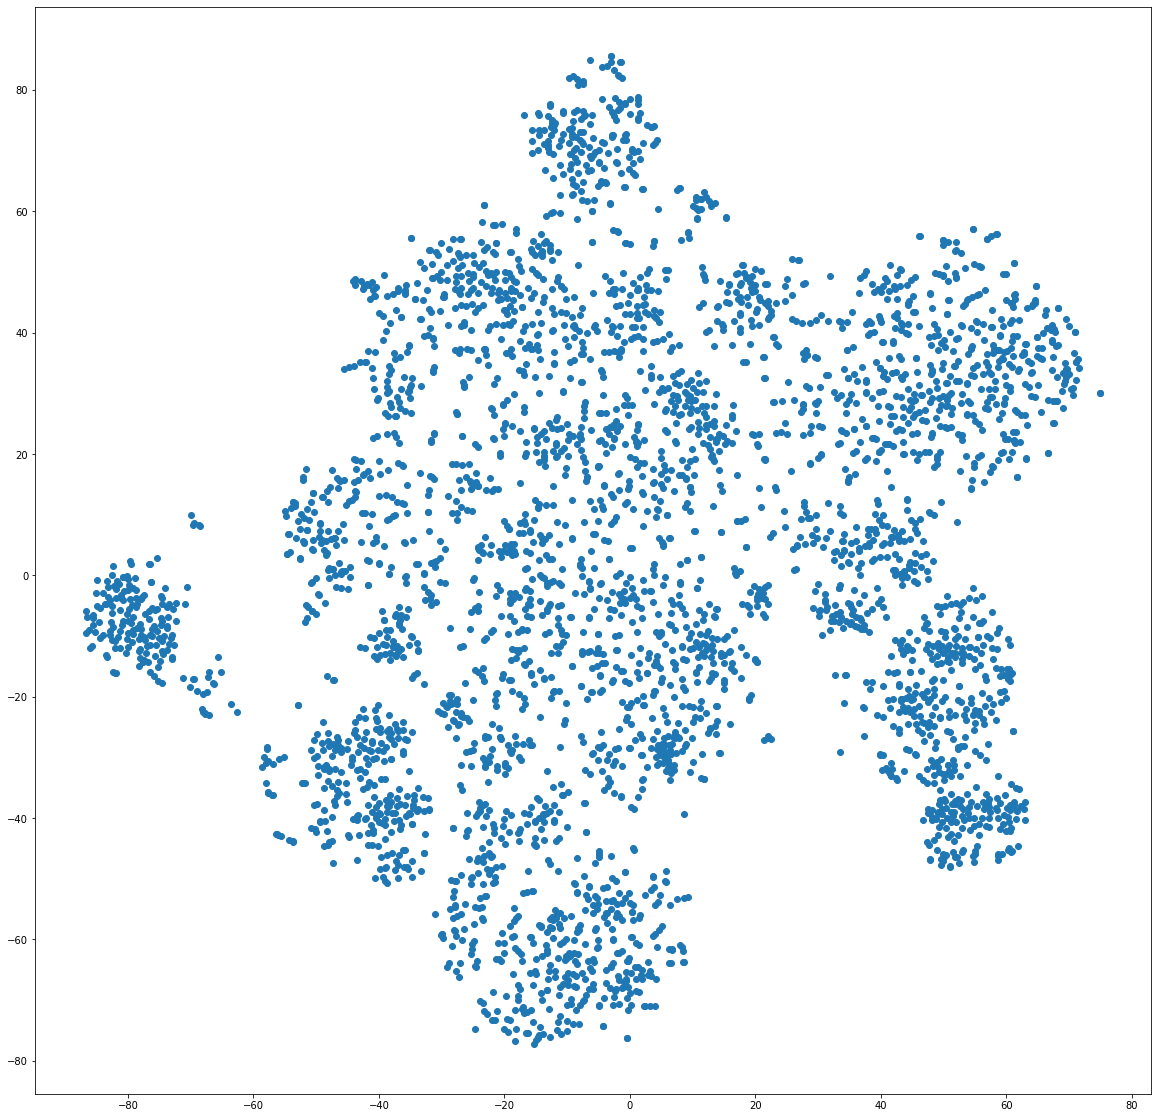

In [27]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
plt.scatter(X[:, 0], X[:, 1], marker='o')


{'4932.YDR264C': '2.3.1.225',
 '4932.YML086C': '1.1.3.37',
 '4932.YKL103C': '3.4.11.22',
 '4932.YLR118C': '3.1.2.-',
 '4932.YNR019W': '2.3.1.26',
 '4932.YPR122W': '3.4.24.-',
 '4932.YGR277C': '2.7.7.3',
 '4932.YHR208W': '2.6.1.42',
 '4932.YJL034W': '3.6.4.10',
 '4932.YIL096C': '2.1.1.313',
 '4932.YGR262C': '3.6.-.-; 2.7.11.1',
 '4932.YDR270W': '7.2.2.8',
 '4932.YIL015W': '3.4.23.35',
 '4932.YJR148W': '2.6.1.42',
 '4932.YJL095W': '2.7.11.1',
 '4932.YAL060W': '1.1.1.4',
 '4932.YOL164W': '3.1.6.-',
 '4932.YNR057C': '6.3.3.3',
 '4932.YBR141C': '2.1.1.286',
 '4932.YNR027W': '2.7.1.35',
 '4932.YJL172W': '3.4.17.4',
 '4932.YBR149W': '1.1.1.117',
 '4932.YLL063C': '2.3.1.-',
 '4932.YBR295W': '3.6.3.3',
 '4932.YKL004W': '2.-.-.-',
 '4932.YAL061W': '1.1.1.303',
 '4932.YGR286C': '2.8.1.6',
 '4932.YGR282C': '3.2.1.58',
 '4932.YFR028C': '3.1.3.48',
 '4932.YIR029W': '3.5.3.4',
 '4932.YPL061W': '1.2.1.4',
 '4932.YGR177C': '2.3.1.84',
 '4932.YGL180W': '2.7.11.1',
 '4932.YIL124W': '1.1.1.101',
 '4932.YB

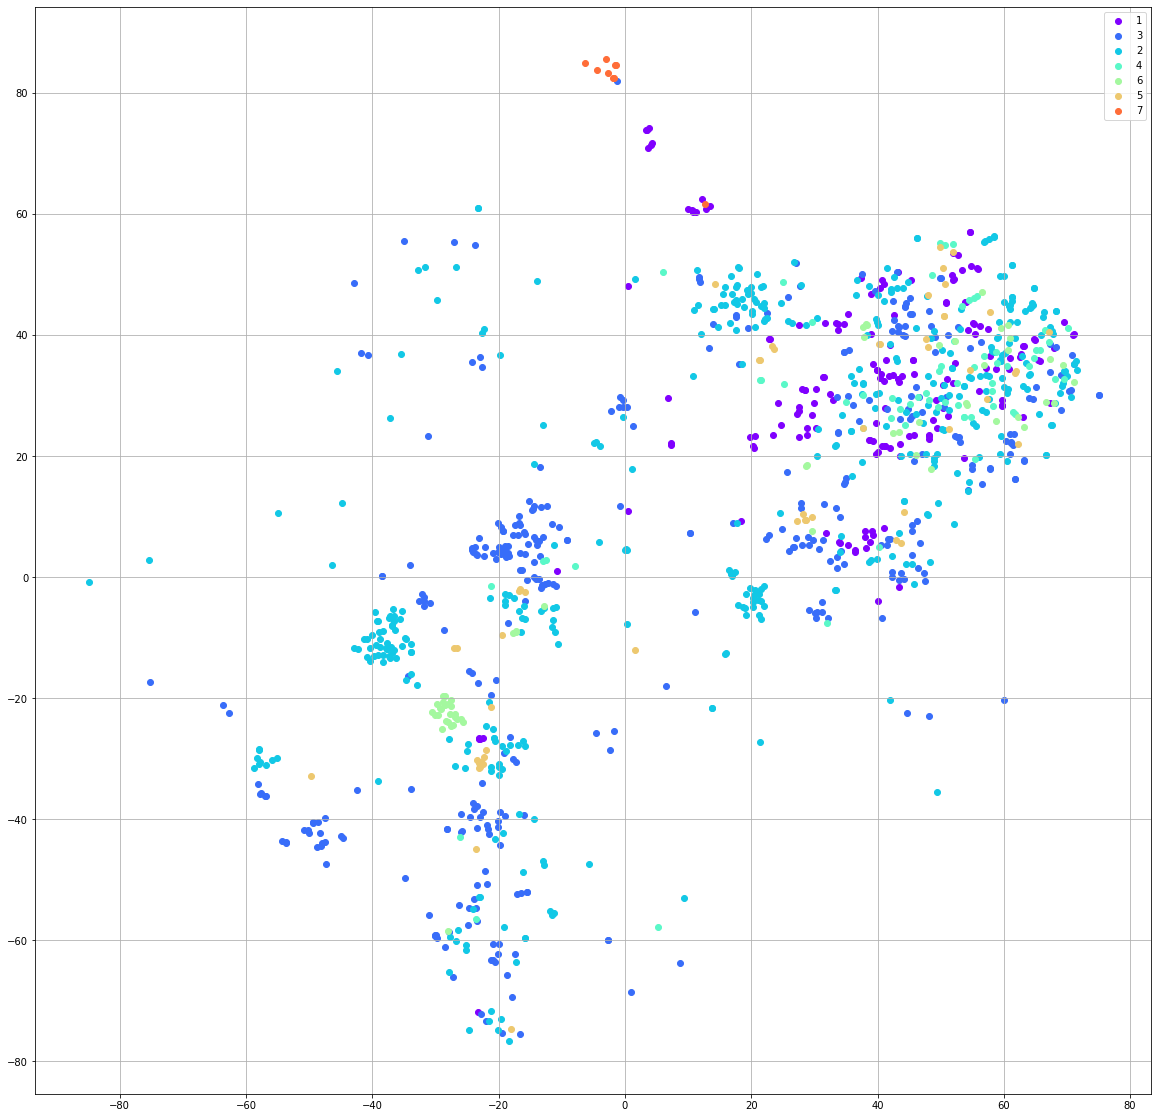

In [31]:
import matplotlib.pyplot as plt

ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()


In [ ]:
size = len(yeast_dict['4932.Q0045'])
embeds = np.zeros((len(yeast_dict), size), dtype=np.float32)

for i, emb in enumerate(yeast_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(yeast_dict.keys()):
    nodemap[i] = m

X = TSNE(n_components=2, verbose=1, n_iter=2000).fit_transform(embeds)
